# Intro

## Load

In [1]:
import os, sys, json, pickle

In [2]:
import numpy as np

In [3]:
import string

In [4]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from nltk.stem.snowball import SnowballStemmer

from bicm import BipartiteGraph as BiG

[nltk_data] Downloading package stopwords to /Users/fabio/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/fabio/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [5]:
from pypdf import PdfReader

In [48]:
from sentence_transformers import SentenceTransformer, util

In [7]:
from sklearn.metrics.pairwise import cosine_similarity

In [8]:
from melt import melt

[nltk_data] Downloading package stopwords to /Users/fabio/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/fabio/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [72]:
import matplotlib.pyplot as plt

## Function

In [13]:
stemmer=SnowballStemmer('english', ignore_stopwords=True)

In [14]:
def text2tokens(text):
        stop_words = list(stopwords.words('english'))
        bad_char=['©', '–', '‘', '’', '“', '”']
        word_tokens = [wt.lower() for wt in word_tokenize(text)]
        out=[]
        for w in word_tokens:
            if not (w in stop_words) and not (w in bad_char) and not (w in string.punctuation) and not ('.' in w) and not (',' in w) and not w.isnumeric():
                # I am removing:
                # - stop words;
                # - punctuation
                # - fractional numbers
                out.append(stemmer.stem(w))
        
        return np.unique(out)

# Read pdf and check

## File

In [9]:
reports_folder='./reports/'
bp='5_BP_PLC/'

In [10]:
bp_files=os.listdir(reports_folder+bp)
bp_files.sort()

## PdfReader

In [11]:
reader = PdfReader(reports_folder+bp+bp_files[0])

Number of pages:

In [12]:
reader.get_num_pages()

56

Metadata (nice, but probably useless)

In [13]:
reader.metadata

{'/Author': 'BP',
 '/CreationDate': 'D:20160307181429Z',
 '/Creator': 'Adobe InDesign CC 2014 (Macintosh)',
 '/ModDate': "D:20160415113505+01'00'",
 '/Producer': 'Adobe PDF Library 11.0',
 '/Title': 'BP Sustainability Report 2015',
 '/Trapped': '/False'}

From the readthedocs: 

_Get the page layout currently being used._
[...]
_SinglePage: Show one page at a time_

I have no idea about what it means.

In [14]:
reader.page_layout

'/SinglePage'

I am not sure it could be of use, but it is the name of the page. To visit the single page and extract the text, simply _reader.pages[x]_ is needed...

In [15]:
reader.page_labels

['FC1',
 'IFC1',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 '10',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '18',
 '19',
 '20',
 '21',
 '22',
 '23',
 '24',
 '25',
 '26',
 '27',
 '28',
 '29',
 '30',
 '31',
 '32',
 '33',
 '34',
 '35',
 '36',
 '37',
 '38',
 '39',
 '40',
 '41',
 '42',
 '43',
 '44',
 '45',
 '46',
 '47',
 '48',
 '49',
 '50',
 '51',
 '52',
 'IBC1',
 'BC1']

In [16]:
reader.pdf_header

'%PDF-1.6'

In [17]:
cacca=reader.flattened_pages

In [18]:
len(cacca)

56

In [19]:
cacca[1].extract_text()

'BP Sustainability Report 2015Who we are\nWe aim to create long-term value for \nshareholders by helping to meet growing demand for energy in a safe and responsible way. We strive to be a world-class operator,  \na responsible corporate citizen and a  \ngood employer.\nBP is one of the world’s leading \nintegrated oil and gas companies – based on market capitalization, proved reserves and production. Through our work we provide customers with fuel for transportation, energy for heat  \nand light, lubricants to keep engines moving and the petrochemicals products used to make everyday  \nitems as diverse as paints, clothes  \nand packaging. \nWe believe a mix of fuels and \ntechnologies is needed to meet growing energy demand, improve efficiency and support the transition  \nto a lower-carbon economy. These  \nare the reasons why our portfolio includes oil, gas and renewables.\nOur projects and operations help to \ngenerate employment, investment  \nand tax revenues in countries and comm

In [20]:
description=reader.pages[1].extract_text(extraction_mode="plain")

In [22]:
description==cacca[1].extract_text()

True

Boh?

### Delete \n

In [29]:
description=' '.join(description.split('\n'))

## Trick from melt

In [32]:
text2tokens(description)

array(['2015who', 'acr', 'across', 'activ', 'africa', 'aim', 'also',
       'america', 'analys', 'anti-corrupt', 'appli', 'appropri', 'around',
       'asia', 'aspect', 'associ', 'assur', 'australasia', 'avail',
       'base', 'began', 'believ', 'bp', 'busi', 'capit', 'chart',
       'citizen', 'cloth', 'comment', 'communiti', 'compact', 'compani',
       'concentr', 'content', 'corpor', 'countri', 'cover', 'creat',
       'custom', 'data', 'decemb', 'demand', 'divers', 'economi',
       'effici', 'employ', 'energi', 'engin', 'environ', 'environment',
       'ernst', 'europ', 'everyday', 'extern', 'filter', 'format',
       'front', 'fuel', 'g4', 'gap', 'gas', 'generat', 'given', 'global',
       'good', 'group', 'grow', 'guidanc', 'guidelin', 'health', 'heat',
       'help', 'hse', 'human', 'identifi', 'imag', 'improv', 'includ',
       'industri', 'influenc', 'inform', 'initi', 'integr', 'invest',
       'ipieca', 'item', 'januari', 'joint', 'keep', 'labour', 'lead',
       'light', 

# SBert

## model='all-MiniLM-L6-v2'

In [37]:
model = SentenceTransformer("all-MiniLM-L6-v2")

In [43]:
sentence_embeddings = model.encode(description)

## The importance of semantic

In [63]:
def semantic_randomizer(text, text_embedding):
    shuffled_text=text.split()
    shuffled_text = np.random.permutation(shuffled_text)
    shuffled_text= ' '.join(shuffled_text)
    shuffled_embedding = model.encode(shuffled_text)
    return util.cos_sim(shuffled_embedding,text_embedding)[0,0].tolist()

In [64]:
semantic_randomizer(description, sentence_embeddings)

0.7892916202545166

In [66]:
n_sample=10**3

In [68]:
random_semantic=[semantic_randomizer(description, sentence_embeddings) for i in range(n_sample)]

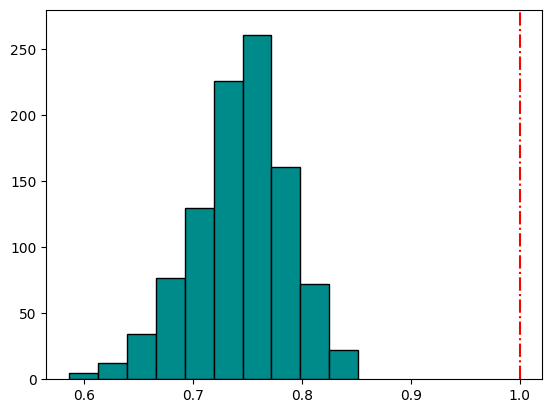

In [80]:
plt.hist(random_semantic, label='randomization', color='darkcyan', edgecolor='k')
plt.vlines(1, 0, 300, color='r', linestyle='-.')
plt.ylim(0,280)
plt.show()

## Calculate the empirical p-value

In [108]:
from scipy.stats._continuous_distns import _distn_names
import scipy.stats as st
import warnings 

In [167]:
def best_fit_distribution(data, bins=200):
    """Model data by finding best fit distribution to data"""
    # Get histogram of original data
    y, x = np.histogram(data, bins=bins, density=True)
    x = (x + np.roll(x, -1))[:-1] / 2.0

    # Best holders
    best_distributions = []

    # Estimate distribution parameters from data
    for ii, distribution in enumerate([d for d in _distn_names if d not in ['levy_stable', 'studentized_range', 'nct2gamiceymmetric']]):
        try:
            print("{:>3} / {:<3}: {}".format( ii+1, len(_distn_names), distribution ), end='\r')

            distribution = getattr(st, distribution)

            # Try to fit the distribution
        
            # Ignore warnings from data that can't be fit
            with warnings.catch_warnings():
                warnings.filterwarnings('ignore')
                
                # fit dist to data
                params = distribution.fit(data)

                # Separate parts of parameters
                arg = params[:-2]
                loc = params[-2]
                scale = params[-1]
                
                # Calculate fitted PDF and error with fit in distribution
                pdf = distribution.pdf(x, loc=loc, scale=scale, *arg)
                sse = np.sum((y - pdf)**2)
                
                # if axis pass in add to plot
                #try:
                #    if ax:
                #        pd.Series(pdf, x).plot(ax=ax)
                #    end
                #except Exception:
                #    pass

                # identify if this distribution is better
                best_distributions.append((distribution, params, sse))
        
        except Exception:
            pass

    
    return sorted(best_distributions, key=lambda x:x[2])

In [168]:
best_distibutions=best_fit_distribution(random_semantic)

In [169]:
best_dist = best_distibutions[0]

In [176]:
best_dist

(<scipy.stats._continuous_distns.mielke_gen at 0x7ff139e53cd0>,
 (4.465824939267456,
  15.178386528449895,
  0.5408595137587391,
  0.24050036052310347),
 618.4327458934176)

In [175]:
def make_pdf(dist, params, size=10000):
    """Generate distributions's Probability Distribution Function """

    # Separate parts of parameters
    arg = params[:-2]
    loc = params[-2]
    scale = params[-1]

    # Get sane start and end points of distribution
    start = dist.ppf(10**-5, *arg, loc=loc, scale=scale) if arg else dist.ppf(10**-5, loc=loc, scale=scale)
    end = dist.ppf(1-10**-5, *arg, loc=loc, scale=scale) if arg else dist.ppf(1-10**-5, loc=loc, scale=scale)

    # Build PDF and turn into pandas Series
    x = np.linspace(start, end, size)
    y = dist.pdf(x, loc=loc, scale=scale, *arg)
    

    return x,y

In [171]:
def get_pvalue(x, dist, params):
    """Generate distributions's Probability Distribution Function """

    # Separate parts of parameters
    arg = params[:-2]
    loc = params[-2]
    scale = params[-1]

    # Get sane start and end points of distribution
    p_val = dist.pdf(x, *arg, loc=loc, scale=scale) if arg else dist.ppf(x, loc=loc, scale=scale)
    p_val += dist.sf(x, *arg, loc=loc, scale=scale) if arg else dist.ppf(x, loc=loc, scale=scale)
    return p_val

In [172]:
pdf = make_pdf(best_dist[0], best_dist[1])

In [173]:
p_value=get_pvalue(1, best_dist[0], best_dist[1])

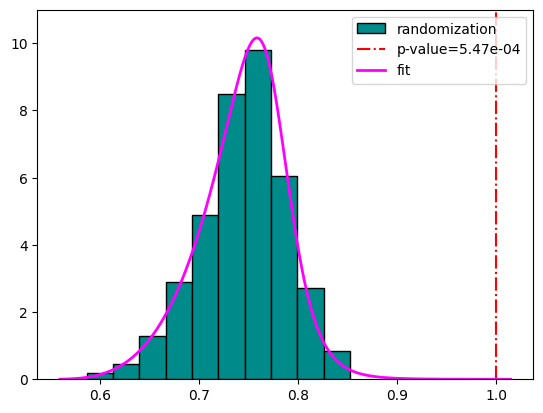

In [174]:
plt.hist(random_semantic, label='randomization', color='darkcyan', edgecolor='k', density=1)
plt.vlines(1, 0, 11, color='r', linestyle='-.', label='p-value={:.2e}'.format(p_value))
plt.plot(pdf[0], pdf[1], lw=2, label='fit', color='magenta')
plt.ylim(0,11)
plt.legend()
plt.show()